***Содержание:***
1. Подготовка данных
2. Исследование задачи
 - Подготовка обучающего набора данных
 - Логистическая регрессия на дисбалансе
 - Дерево решений на дисбалансе
 - Случайный лес на дисбалансе
3. Борьба с дисбалансом
 - Логистическая регрессия на сбалансированных данных
 - Дерево решений на дисбалансе на сбалансированных данных
 - Случайный лес на дисбалансе на сбалансированных данных
4. Тестирование
5. Выводы


# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import accuracy_score #Accuracy
from sklearn.metrics import recall_score #Recall
from sklearn.metrics import precision_score #Precision
from sklearn.metrics import f1_score #F1 ->1
from sklearn.metrics import roc_auc_score #ROC AUC score ->1

from sklearn.metrics import roc_curve #ROC AUC
from sklearn.metrics import precision_recall_curve #

from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report

In [ ]:
try:
    df = pd.read_csv('/datasets/Churn.csv')#, sep='\,')
    
except:
    df = pd.read_csv('C:\\Users\\с\\Desktop\\data_science\\DATA_CSV\\Churn.csv') #, sep='\,')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В соответствии с заданием исходный датасет состоит из следующих данных:

__Признаки__
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

__Целевой признак__
- Exited — факт ухода клиента


Таким образом, необходимо обучить модель классификации, которая будет прогнозировать класс "1" (целевой признак "Exited"), если есть основания считать, что клиент в ближайшее время уйдет из банка.

Для начала приведем в порядок названия столбцов 

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.rename(columns = {'rownumber':'row_number', 'customerid':'customer_id', 'creditscore':'credit_score','numofproducts':'num_of_products', 'hascrcard':'has_cr_card',
       'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'}, inplace = True)

Для обучения модели имеются следующие исходные данные:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


На первый взгляд данные имеют довольно высокое качество:
- все признаки, кроме одного не содержат пробелов.
- доля пропусков в признаке tenure - менее 10%.
- данные представлены в логически обоснованных форматах, кроме tenure (возможно, имеет смысл преобразовать в int)

Два признака "geography" (страна проживания) и "gender"(пол) представлены в текстовом формате и, очевидно, придется их подвергнуть кодированию.

В составе данных имеются избыточные признаки. В частности, маловероятно, что признаки: 
- row_number — индекс строки в данных
- customer_id — уникальный идентификатор клиента
- surname — фамилия

влияют на то, что клиент потенциально готов покинуть банк. 
Индекс строки и Идентификатор клиента сугубо служебная информация и вообще никак не связана с финансовыми отношениями клиента и банка. Что касается Фамилии...

In [ ]:
# Общее кол-во клиентов, покинувших банк.
df.query('exited==1')['surname'].count()

2037

In [ ]:
# Группировка клиентов, покинувших банк, по фамилиям.
df.query('exited==1')['surname'].value_counts()

Lin         9
Smith       9
McGregor    9
Martin      9
Wang        7
           ..
Olson       1
Dunn        1
McVey       1
Chidimma    1
Berkeley    1
Name: surname, Length: 1188, dtype: int64

...если из 2-х тысяч человек, покинувших банк, было аж 9 МакГрегоров или Смитов, то это не означает, что фамилия клиента влияет на то, уйдет ли он вскоре из банка! 

Таким образом, для обучения модели целесообразно использовать следующие признаки:
- credit_score — кредитный рейтинг
- geography — страна проживания (текстовый)
- gender — пол (текстовый)
- age — возраст
- tenure — сколько лет человек является клиентом банка
- balance — баланс на счёте
- num_of_products — количество продуктов банка, используемых клиентом
- has_cr_card — наличие кредитной карты
- is_active_member — активность клиента
- estimated_salary — предполагаемая зарплата

Из которых два признака - текстовые.

Не откладывая, удалим избыточные признаки из рабочего датасета:

In [ ]:
#удаление избыточных ("мусорных") параметров
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

Далее следует обратить внимание на признак __"tenure__ — сколько лет человек является клиентом банка"

Признак содержит около 9% пропусков:

In [ ]:
df['tenure'].isna().mean()*100

9.09

при этом всего 11 уникальных значений признака:

In [ ]:
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Клиенты по "сроку обслуживания" распределяются практически равномерно (см. ниже), если не считать тех, кто "и года не протянул" и совсем преданных (10 лет обслуживания)

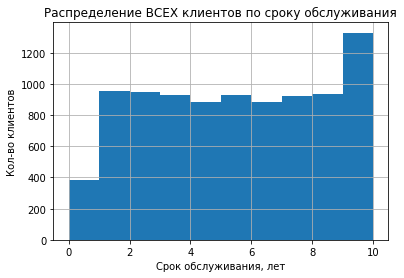

In [ ]:
df['tenure'].plot(kind='hist', grid=True)
plt.title("Распределение ВСЕХ клиентов по сроку обслуживания")
plt.ylabel("Кол-во клиентов")
plt.xlabel('Срок обслуживания, лет')
plt.show()

"Сбежавшие клиенты" по "сроку обслуживания" распределяются практически также, как вообще все клиенты (см. ниже). Т.е. нельзя однозначно сказать, например, что "бегут только новички или только ветераны".

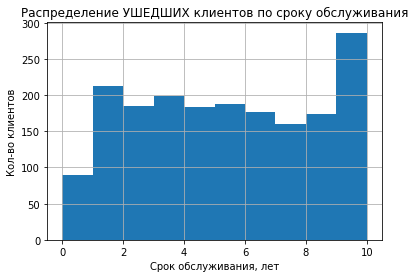

In [ ]:
df.query('exited==1')['tenure'].plot(kind='hist', grid=True)
plt.title("Распределение УШЕДШИХ клиентов по сроку обслуживания")
plt.ylabel("Кол-во клиентов")
plt.xlabel('Срок обслуживания, лет')
plt.show()

9% пропусков в одном из важных параметров с одной стороны терять жаль, но с другой стороны заполнение пропусков - это самостоятельная непростая задача. Поэтому, обучать модель предлагается на данных после удаления пустых строк.

In [ ]:
# удаляем сразу пропуски в tenure
df = df.dropna(subset=['tenure'])
df = df.reset_index(drop=True)

**Лирическое отступление:** 
Медианой заполнял. Но медиана заметно искажает распределние tenure: появляется искусственный "пик" на значении "5". 

Далее ознакомимися с исходными данными в остальных параметрах.

In [ ]:
df['credit_score'].agg(['min','max'])

min    350
max    850
Name: credit_score, dtype: int64

Очевидных недостатков не наблюдается. 

In [ ]:
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Имеем данные по рем странам. Дефектов не наблюдается. 

In [ ]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

Всё логично: мужской пол и женский.

In [ ]:
df['age'].agg(['min','max'])

min    18
max    92
Name: age, dtype: int64

Данные без отклонений. Клиенты от 18-ти до 92-х лет.

In [ ]:
df['balance'].agg(['min','max'])

min         0.00
max    250898.09
Name: balance, dtype: float64

Ничего странного: у кого-то на счету "0", у кого-то - тыщи.

In [ ]:
df['num_of_products'].agg(['min','max'])

min    1
max    4
Name: num_of_products, dtype: int64

Всё нормально. Ничего странного.

In [ ]:
df['has_cr_card'].unique()

array([1, 0])

Логично: карта либо есть, либо - нет.

In [ ]:
df['is_active_member'].unique()

array([1, 0])

Тут тоже всё логично: активный клиент - получи "1". Не акьтвный - "баранку"

In [ ]:
df['estimated_salary'].agg(['min','max'])

min        11.58
max    199992.48
Name: estimated_salary, dtype: float64

Всё как в жизни: кто-то лопатой деньги гребет, кто-то - "от зарплаты до зарплаты". Но данные нормальные.

In [ ]:
df['exited'].unique()

array([1, 0])

С целевым праметром тоже всё "ОК". Приступаем к решению задач проекта.

## Исследование задачи

В исходном датасете классы представлены в следующей пропорции:

In [ ]:
df['exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

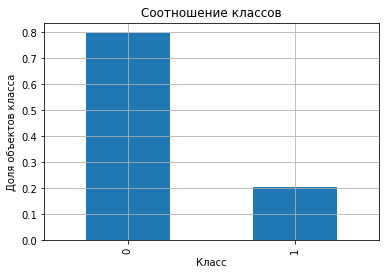

In [ ]:
df['exited'].value_counts(normalize=True).plot(kind='bar', grid=True)
plt.title("Соотношение классов")
plt.ylabel("Доля объектов класса")
plt.xlabel('Класс')
plt.show()

Класс "1" - 20,37%. Класс "0" - 79,63%  Т.е. баланс (дисбаланс) "1 к 4".

Принимая во внимание, что перед нами стоит задача бинарной классификации и, исходя из имеющихся данных, целесообразно построить все дальнейшие действия по следующему плану:

1. Готовим на неподготовленных (несбалансированных) данных следующие выборки: обучающую, валидационную и тестовую.
2. Обучаем на неподготовленных (несбалансированных) данных следующие модели классификации:
- "логистическая регрессия"
- "дерево решений"
- "случайный лес".
3. Для каждой модели, на неподготовленных (несбалансированных) данных, пытаемся максимизировать целевую метрику (f1) до максимального уровня путем подбора гиперпараметров (порог, глубина дерева и т.п.)
4. Устраняем дисбаланс классов (взвешивание классов, upsampling и downsampling.) и для каждого из способов устранения дисбаланса обучаем модели (п.2).
5. По результатам обучения на сбалансированных данных выбираем лучший способ устранения дисбаланса и лучшую модель.
6. Повышаем качество лучшей моедли на сбалансированных данных: подбираем гиперпараметры для достижения максимальной целевой метрики (f1).
7. Тестируем лучшую модель на тестовой выборке, подготовленной на шаге 1.

Приступим 

### Подготовка обучающей, валидацинной и тестовой выборок

Т.к. в рабочем датасете два текстовых (нечисловых) параметра "geography" и "gender" (подробно см. раздел 1), необходимо провести кодирование. Выполним прямое кодирование (OHE). 

In [ ]:
#прямое кодиование
df_ohe = pd.get_dummies(df, drop_first=True)

Подготовим наборы параметров и целевой признак.

In [ ]:
# набор признаков
features = df_ohe.drop('exited', axis=1)
features.shape

(9091, 11)

In [ ]:
# целевой признак
target = df_ohe['exited']
target.shape

(9091,)

Сформируем обучающую, валидационную и тестовую выборки.

In [ ]:
#выделение обучающей выборки
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, train_size= 0.6, random_state=12345)

In [ ]:
#формирование валидационной и тествой выборок
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size= 0.5, random_state=12345)

Рабочий датасет содержит числовые параметры с разным масштабом. Проведем стандартизацию числовых признаков

In [ ]:
#список числовых параметров подлежащих стандартизации
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary','num_of_products']

In [ ]:
#стандартизация числовых параметров
scaler = StandardScaler()
scaler.fit(features_train[numeric])
#стандартизация числовых параметров в обучающей выборке
features_train[numeric] = scaler.transform(features_train[numeric])

#стандартизация числовых параметров в валидационной выборке
features_valid[numeric] = scaler.transform(features_valid[numeric])

#стандартизация числовых параметров в тестовой выборке
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_83/855233834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_83/855233834.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8483,0.809075,-1.039327,-1.025995,0.554904,-0.908179,1,0,0.019508,0,0,0
3431,-1.152518,-1.227561,0.696524,0.480609,-0.908179,0,0,0.056167,0,0,1
6770,-0.398853,0.090079,1.385532,-1.237830,-0.908179,1,1,0.848738,0,0,1
1350,-0.749875,-0.286389,0.352020,-1.237830,0.809300,1,1,-0.894953,0,0,1
4047,-1.028628,-0.756975,-0.336987,-1.237830,0.809300,0,1,-1.284516,0,0,1


Итак. Обучающие данные подготовлены. Согласно задания, устранение дисбаланса на данном этапе проекта не требуется. Т.о. можно переходить к обучению моделей на несбалансированных данных.

In [ ]:
# набор признаков
print('Обучающие параметры:', features_train.shape)
print('Обучающий целевой параметр:', target_train.shape)
print('-------------------------------------')
print('Валидационные параметры:', features_valid.shape)
print('Валидационный целевой параметр:', target_valid.shape)
print('-------------------------------------')
print('Тестовые параметры:', features_test.shape)
print('Тестовый целевой параметр:', target_test.shape)

Обучающие параметры: (5454, 11)
Обучающий целевой параметр: (5454,)
-------------------------------------
Валидационные параметры: (1818, 11)
Валидационный целевой параметр: (1818,)
-------------------------------------
Тестовые параметры: (1819, 11)
Тестовый целевой параметр: (1819,)


### Логистическая регрессия (на дисбалансе)

Подготовим и обучим модель логистической регрессии на несбалансированных данных

In [ ]:
lr = LogisticRegression(random_state=12345, solver='liblinear')
lr.fit(features_train, target_train)
predicted_valid = lr.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.30400000000000005
ROC AUC score: 0.5844876366066153


Модель однозначно выдаёт низкое значение метрики F1 и метрики ROC AUC. Модель немногим лучше "честной монеты".
Попробуем подобрать порог. Используем функцию "predict_proba". Возможно это даст какое-либо улучшение целевой метрики F1.

In [ ]:
probabilities_valid = lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

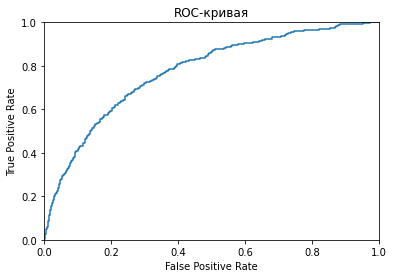

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


Полученная ROC-кривая заметно лучше "случайной модели", но наша целевая метрика F1 и необходимо максимизировать именно её. Подготовим цикл, который будет перебирать "порог" и замерять целевую метрику. 

In [ ]:
best_tres=0
best_f1=0
best_ROC_AUC=0
for threshold in np.arange(0.2, 0.4, 0.02):
    predicted_valid =  probabilities_one_valid > threshold  
    f1 = f1_score(target_valid, predicted_valid)
    roc = roc_auc_score(target_valid, predicted_valid)
    #print("Порог = {:.2f} | F1 score = {:.4f} | ROC AUC score = {:.4f}".format(
        #threshold, f1, roc))
    if f1>best_f1:
        best_tres=threshold
        best_f1=f1
        best_ROC_AUC=roc
print('-----------------------------------------------------')
print('Лучший порог:', best_tres)
print('Лучшая метрика F1:', best_f1)
print('Лучший метрика ROC_AUC:', best_ROC_AUC)

-----------------------------------------------------
Лучший порог: 0.22
Лучшая метрика F1: 0.5072886297376094
Лучший метрика ROC_AUC: 0.7104841723162334


Итак. Выявлен порого 0.22, который заметно повышает качество модели на несбалансированных данных: F1 повышается с 0.3040 до 0.5073, ROC_AUC повышаестя с 0.5845 до 0.7105. 

Однако, заданный проектом нижний предел целевой метрики (F1>=0.59) не достигнут. 

Перейдем к следующей модели.

### Дерево решений (на дисбалансе)

Подготовим и обучим модель "дерево решений" на несбалансированных данных

In [ ]:
dtc = DecisionTreeClassifier(random_state=12345)#max_depth=depth
dtc.fit(features_train, target_train)
predicted_valid = dtc.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.4926764314247669
ROC AUC score: 0.6797786314764468


Значение целевой метрики F1 и метрики ROC_AUC заметно лучше, чем у "логистической регрессии" до применения порога. Однако, до заданного значения целевой метрики еще далеко. Попробуем подобрать глубину дерева. 

Для этого используем функцию GridSearchCV, которая подберет оптимальные параметры (ищем локальный максимум)

Задаем параметры для подбора

In [ ]:
#здесь и далее для ускорения проверки оставлено только финальное значение искомого параметра
# для примера закоментированы варианты подбора
params = {'max_depth': [6]} #list(range(5,15,1))}

Задаем модель для которой будут подбираться оптимальные параметры для достижения наилучшего показателя F1-меры.

In [ ]:
dtc = DecisionTreeClassifier(random_state=12345)

In [ ]:
clf = GridSearchCV(dtc, params, scoring='f1', cv=3, n_jobs=-1)

Запускаем подбор параметров с замером времени

In [ ]:
%%time
clf.fit(features_train,target_train)

CPU times: user 157 ms, sys: 2.87 ms, total: 160 ms
Wall time: 159 ms


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1, param_grid={'max_depth': [6]}, scoring='f1')

Понятно, что время показывает заниженное, т.к. фактически оптимальный параметр мной уже подобран заранее. 
Тем не менее мы имеем следующие параметры:

In [ ]:
clf.best_score_

0.5337649476519607

Лучшая F1-мера 0.5337

In [ ]:
clf.best_params_

{'max_depth': 6}

Лучшая глубина дерева - 6. 

Далее, используя найденный оптимальный параметр, заново обучим модель и проверим её на валидацинных данных:

In [ ]:
dtc_best = DecisionTreeClassifier(random_state=12345, max_depth=clf.best_params_['max_depth'])
dtc_best.fit(features_train, target_train)
predicted_valid = dtc_best.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5606837606837607
ROC AUC score: 0.7022394557272156


Итак. Модель __"дерева решений"__ выдаёт на несбалансированных валидационных данных __F1-меру равную 0.5607__, ROC_AUC - 0.7022. 
Это заметно лучше, чем "логистическая регрессия", но заданный проектом нижний предел целевой метрики (F1>=0.59) всё-ещё не достигнут. 

Перейдем к следующей модели.

### Случайный лес (на дисбалансе)

Подготовим и обучим модель "случайный лес" на несбалансированных данных

In [ ]:
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(features_train, target_train)
predicted_valid = rfc.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5851239669421487
ROC AUC score: 0.7170519661964779


Значение целевой метрики F1 и метрики ROC_AUC заметно лучше, чем у "логистической регрессии" до применения порога и у "дерева решений" до оптимизации. Однако, до заданного значения целевой метрики еще далеко. Попробуем подобрать гиперпараметры: кол-во деревьев, глубину деревьев, количество функций,  которые следует учитывать при поиске лучшего разделения. 

Для этого используем функцию GridSearchCV, которая подберет оптимальные параметры (ищем локальный максимум)

Задаем параметры для подбора

In [ ]:
# для сокращения времение проверки я в параметрах оставил только самые успешные 
# остальные для примера закомментированы в соответсвующих строках

params = {
    'n_estimators': [316],# list(range(310,330,2)),#list(map(int, np.floor(np.logspace(2, 3, 3)))),
    'max_depth': [16], #[14,15,16,17,18,20], #list(range(5,30,5)),
    'max_features': [4] #[3,4,5]
}

Задаем модель для которой будут подбираться оптимальные параметры для достижения наилучшего показателя F1-меры.

In [ ]:
rfc = RandomForestClassifier(random_state=12345)

In [ ]:
clf = GridSearchCV(rfc, params, scoring='f1', cv=3, n_jobs=-1)

Запускаем подбор параметров с замером времени

In [ ]:
%%time
clf.fit(features_train,target_train)

CPU times: user 9.77 s, sys: 27.1 ms, total: 9.79 s
Wall time: 9.99 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [16], 'max_features': [4],
                         'n_estimators': [316]},
             scoring='f1')

Время также показывает заниженное, т.к. фактически оптимальный параметр мной уже подобран заранее. 

Но оптимальные параметры подобраны:

In [ ]:
clf.best_score_

0.5678009776387413

Лучшая F1-мера 0.5708

In [ ]:
clf.best_params_

{'max_depth': 16, 'max_features': 4, 'n_estimators': 316}

Лучшая глубина дерева - 16, деревьев - 316, функций - 4. 

Далее, используя найденный оптимальный набор параметров, заново обучим модель и проверим её на валидацинных данных:

In [ ]:
rfc_best = RandomForestClassifier(random_state=12345,
                                      max_depth=clf.best_params_['max_depth'], 
                                      n_estimators=clf.best_params_['n_estimators'], 
                                      max_features=clf.best_params_['max_features'], 
                                      min_samples_leaf=1,
                                      min_samples_split=2)
rfc_best.fit(features_train, target_train)
predicted_valid = rfc_best.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5864909390444811
ROC AUC score: 0.7180312448804157


Модель __"случайный лес"__ выдаёт на несбалансированных валидационных данных __F1-меру равную 0.5865__, ROC_AUC - 0.7180. 
Это заметно лучше, чем "логистическая регрессия", но заданный проектом нижний предел целевой метрики (F1>=0.59) всё-ещё не достигнут. 

Для удобства соберем лучшие результаты моделей в общую таблицу:

In [ ]:
results=[[0.5073,0.7105],[0.5607,0.7022],[0.5865,0.7180]]
index=['Логистическая регрессия','Дерево решений','Случайный лес']
res=pd.DataFrame(data=results,index=index, columns=['F1','ROC-AUC'])
res

,F1,ROC-AUC
Логистическая регрессия,0.5073,0.7105
Дерево решений,0.5607,0.7022
Случайный лес,0.5865,0.7180


**Вывод** 

Из сводной таблицы очевидно, что макисмальное значение целевой метрики (f1) на несбалансированных данных показала оптимизированная модель "случайный лес":  F1_score = 0.5865 и ROC_AUC_score = 0.7180

Проектом установлен минимальный порог целевой метрики f1=0.59. 

Даже на несбалансированных данных этот порог уже почти достигнут.

Продолжим. Попытаемся достигнуть лучшего результата на сбалансированных данных.

## Борьба с дисбалансом

Для дальнейшего удобства сформируем две функции: для downsampling и для upsampling, которые на входе принимают соответсвующие обучающие выборки и коэффициенты-мультипликаторы.

In [ ]:
#даунсэмплинг
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [ ]:
#апсэмплинг
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # < добавьте перемешивание >
    features_upsampled = shuffle(features_upsampled, random_state=12345, n_samples=None)
    target_upsampled = shuffle(target_upsampled, random_state=12345, n_samples=None)
    return features_upsampled, target_upsampled

Далее вызовем функции и сформируем новые сбалансированные обучающие выборки: 
- features_downsampled - уменьшенная выборка (класс "0" уменьшен до размера класса "1") 
- features_upsampled- увеличенная выборка (класс "1" увеличен до размера класса "0")

In [ ]:
# вызов даунсэмплинга
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [ ]:
# вызов апсэмплинга
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Обучающие выборки готовы. Приступим к обучению моделей.

### Логистическая регрессия (на сбалансированных данных)

Подготовим и обучим модель логистической регрессии:
- на несбалансированных данных, путем взвешивания классов (добавим параметр class_weight='balanced')
- на уменьшенной выборке (features_downsampled)
- на увеличенной выборке (features_upsampled)

Полученные результаты соберем в сводной таблице и сделаем вывод.

#### Начнем с обучения модели на несбалансированных данных, путем взвешивания классов.

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.509731232622799
ROC AUC score: 0.7165604861051031


#### Модель на уменьшенной выборке

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5044883303411131
ROC AUC score: 0.7144555891594586


#### Модель на увеличенной выборке

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)

print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5085972850678734
ROC AUC score: 0.7175784205265648


In [ ]:
results=[[0.5097,0.7166],[0.5045,0.7145],[0.5086,0.7176]]
index=['Взвешивание классов','Даунсэмплинг','Апсэмплинг']
res=pd.DataFrame(data=results,index=index, columns=['F1','ROC-AUC'])
res

,F1,ROC-AUC
Взвешивание классов,0.5097,0.7166
Даунсэмплинг,0.5045,0.7145
Апсэмплинг,0.5086,0.7176


**Вывод**

Наилучший результат целевой метрики дала модель логистической регрессии на взвешенных классах: F1=0.5097. 

При этом лучшая метрика ROC_AUC достигается на увеличенной выборке: 0.7176

### Дерево решений (на сбалансированных данных)

Подготовим и обучим модель "дерево решений":
- на несбалансированных данных, путем взвешивания классов (добавим параметр class_weight='balanced')
- на уменьшенной выборке (features_downsampled)
- на увеличенной выборке (features_upsampled)

Полученные результаты также соберем в сводной таблице и сделаем вывод.

#### Начнем с обучения модели на несбалансированных данных, путем взвешивания классов.

In [ ]:
model_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree.fit(features_train, target_train)

predicted_valid = model_tree.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.47248322147651006
ROC AUC score: 0.6668013481648649


#### Модель на уменьшенной выборке

In [ ]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_downsampled, target_downsampled)

predicted_valid = model_tree.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5076507650765076
ROC AUC score: 0.7171697741584554


#### Модель на увеличенной выборке

In [ ]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_upsampled, target_upsampled)

predicted_valid = model_tree.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.46195652173913043
ROC AUC score: 0.6598847322722027


In [ ]:
results=[[0.4735,0.6669],[0.5077,0.7172],[0.4620,0.6599]]
index=['Взвешивание классов','Даунсэмплинг','Апсэмплинг']
res=pd.DataFrame(data=results,index=index, columns=['F1','ROC-AUC'])
res

,F1,ROC-AUC
Взвешивание классов,0.4735,0.6669
Даунсэмплинг,0.5077,0.7172
Апсэмплинг,0.4620,0.6599


**Вывод**

Наилучший результат целевой метрики дало "решающее дерево" на уменьшенной выборке: F1=0.5077. 
Лучшая метрика ROC_AUC также достигается на уменьшенной выборке: 0.7172

### Случайный лес (на сбалансированных данных)

Подготовим и обучим модель "случайный лес":
- на несбалансированных данных, путем взвешивания классов (добавим параметр class_weight='balanced')
- на уменьшенной выборке (features_downsampled)
- на увеличенной выборке (features_upsampled)

Полученные результаты также соберем в сводной таблице и сделаем вывод.

#### Начнем с обучения модели на несбалансированных данных, путем взвешивания классов.

In [ ]:
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest.fit(features_train, target_train)

predicted_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5757575757575758
ROC AUC score: 0.7108293128298393


#### Модель на уменьшенной выборке

In [ ]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_downsampled, target_downsampled)

predicted_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.5878906250000001
ROC AUC score: 0.7791487270297484


#### Модель на увеличенной выборке

In [ ]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_upsampled, target_upsampled)

predicted_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.6088235294117647
ROC AUC score: 0.7412256077694351


In [ ]:
results=[[0.5338,0.6898],[0.5905,0.7697],[0.5781,0.7244]]
index=['Взвешивание классов','Даунсэмплинг','Апсэмплинг']
res=pd.DataFrame(data=results,index=index, columns=['F1','ROC-AUC'])
res

,F1,ROC-AUC
Взвешивание классов,0.5338,0.6898
Даунсэмплинг,0.5905,0.7697
Апсэмплинг,0.5781,0.7244


**Вывод**

Наилучший результат целевой метрики дал "случайный лес" на уменьшенной выборке: F1=0.5905. 
Лучшая метрика ROC_AUC также достигается на уменьшенной выборке: 0.7697

### Наилучшая модель 

__Наилучший результат__ после балансирования классов показала __модель "случайный лес" на уменьшенной выборке__. 

Получены следующие показатели:
- F1-мера = 0.5905
- ROC-AUC = 0.7697

Именно эту модель целесообразно оптимизировать путем подбора гиперпараметров и в дальнейшем тестировать.

Второй по качеству результат также показал "случайный лес", но на увеличенной выборке:
- F1-мера = 0.5781
- ROC-AUC = 0.7244

В случае, если тест не даст удовлетворительный результат, можно будет использовать вторую по качеству модель.
Приступим.

### Оптимизация лучшей модели

In [ ]:
# для сокращения времение проверки я в параметрах оставил только самые успешные 
# остальные для примера закомментированы в соответсвующих строках

params = {
    'n_estimators': [350], #list(range(100,500,50)),
    'max_depth': [30], #list(range(20,50,10)),
    'max_features': [4], #[3,4,5,6], #['auto', 'sqrt', 'log2']
    'min_samples_leaf': [2], #range (1,3),
    'min_samples_split': [2] #range (2,6,2)
}

Задаем модель для которой будут подбираться оптимальные параметры для достижения наилучшего показателя F1-меры.

In [ ]:
#здесь я добавил парамаетр class_weight='balanced'
rfc = RandomForestClassifier(random_state=12345, class_weight='balanced')

In [ ]:
clf = GridSearchCV(rfc, params, scoring='f1', cv=3, n_jobs=-1)

Запускаем подбор параметров

In [ ]:
clf.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [30], 'max_features': [4],
                         'min_samples_leaf': [2], 'min_samples_split': [2],
                         'n_estimators': [350]},
             scoring='f1')

In [ ]:
clf.best_score_

0.5890585286746277

In [ ]:
clf.best_params_

{'max_depth': 30,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 350}

Далее, используя найденный оптимальный набор параметров, заново обучим модель и проверим её на валидацинных данных:

In [ ]:
model_forest = RandomForestClassifier(random_state=12345,
                                      max_depth=clf.best_params_['max_depth'], 
                                      n_estimators=clf.best_params_['n_estimators'], 
                                      max_features=clf.best_params_['max_features'], 
                                      min_samples_leaf=clf.best_params_['min_samples_leaf'],
                                      min_samples_split=clf.best_params_['min_samples_split']) 

model_forest.fit(features_upsampled, target_upsampled)
predicted_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predicted_valid))
print('ROC AUC score:', roc_auc_score(target_valid, predicted_valid))

F1 score: 0.6305555555555555
ROC AUC score: 0.7608111814481913


Оптимизированный "случайный лес" обученный на увеличенной выборке дал на валидационных данных приемлемый результат: 
- F1-мера = 0.6306
- ROC-AUC = 0.7608

Полученный результат, во-первых, превышает заданный проектом порог, во-вторых, позволяет рассчитывать на успешный тест.

Итак. В качестве лучшей модели назначим модель "случайный лес" обученный на увеличенной выборке.

In [ ]:
best_model = model_forest

Далее протестируем обученную модель на тестовой выборке.

## Тестирование модели

In [ ]:
predicted_best = best_model.predict(features_test)
print('F1 score:', f1_score(target_test, predicted_best))
print('ROC AUC score:', roc_auc_score(target_test, predicted_best))

F1 score: 0.6153846153846154
ROC AUC score: 0.7617113812617899


In [ ]:
probabilities = best_model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

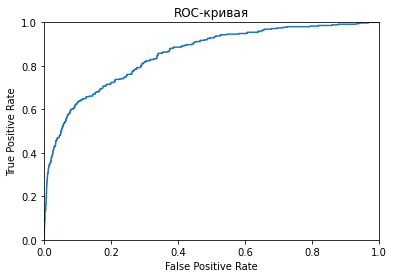

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Вывод

По результатам теста оптимизированная модель "случайный лес", обученная на увеличенной (сбалансированной) выборке показала следующие результаты:
- F1-мера = 0.6154 > 0,59 
- ROC-AUC = 0.7617

Таким образом, цель проекта достигнута.

In [ ]:
print("Спасибо за внимание!")

Спасибо за внимание!
